## Welcome To The Tutorial 2 Of Responsible AI

#### Welcome to our tutorial on loading ACS-PUMS data with customized target objectives and input features, followed by an in-depth analysis using the powerful Fairlearn library. 

In this comprehensive guide, we will walk you through the process of acquiring, pre-processing, and loading the American Community Survey Public Use Microdata Sample (ACS-PUMS) data. The focus of this tutorial goes beyond just data loading – we will explore how to tailor the dataset to your specific needs by selecting target objectives and input features that align with your research or analysis goals.

But that's not all! In the last tutorial, we introduced you to the Fairlearn library, a valuable tool for addressing fairness and bias concerns in machine learning models. We will revisit this library to demonstrate how it can be applied to your custom-loaded ACS-PUMS data. By doing so, you'll gain the ability to measure and mitigate any fairness disparities in your models, ensuring that your analysis is not only informative but also ethically sound.

#### The data customization which we will learn today, will be using in all the later tutorials in this course. 

To use the data at first we will need to install a special library called Folktables [https://github.com/socialfoundations/folktables]

In [1]:
import sys

!{sys.executable} -m pip install folktables

#### Now that we have installed the required library, we will see at first how to load data with Folktable

We will load census from a single state 'Arizona'.

In [5]:
from folktables import ACSDataSource, ACSIncome

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["AR"], download=True)


In [8]:
acs_data

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,CIT,CITWP,COW,DDRS,DEAR,DEYE,DOUT,DPHY,DRAT,DRATX,DREM,ENG,FER,GCL,GCM,GCR,HINS1,HINS2,HINS3,HINS4,HINS5,HINS6,HINS7,INTP,JWMNP,JWRIP,JWTR,LANX,MAR,MARHD,...,PWGTP41,PWGTP42,PWGTP43,PWGTP44,PWGTP45,PWGTP46,PWGTP47,PWGTP48,PWGTP49,PWGTP50,PWGTP51,PWGTP52,PWGTP53,PWGTP54,PWGTP55,PWGTP56,PWGTP57,PWGTP58,PWGTP59,PWGTP60,PWGTP61,PWGTP62,PWGTP63,PWGTP64,PWGTP65,PWGTP66,PWGTP67,PWGTP68,PWGTP69,PWGTP70,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000015,7,1,1000,3,5,1013097,91,19,1,NaN,1.0,2.0,2,2,2.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,2,2,2,1,2,2,2,0.0,NaN,NaN,NaN,2.0,5,NaN,...,7,90,175,7,164,93,96,95,90,99,87,7,164,82,98,201,172,96,7,90,81,8,82,86,90,8,180,181,181,171,8,89,90,167,8,90,88,7,92,169
1,P,2018GQ0000018,7,1,200,3,5,1013097,91,84,1,NaN,NaN,1.0,1,1,1.0,1.0,NaN,NaN,1.0,NaN,NaN,2.0,NaN,NaN,2,2,1,1,2,2,2,0.0,NaN,NaN,NaN,2.0,2,2.0,...,87,169,173,87,9,165,7,85,91,92,92,82,95,166,9,97,89,7,6,88,6,86,87,8,88,92,93,8,167,173,179,180,9,85,89,183,9,89,92,172
2,P,2018GQ0000044,7,1,200,3,5,1013097,78,19,1,NaN,1.0,2.0,2,2,2.0,2.0,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,1,2,2,2,2,2,2,0.0,10.0,NaN,10.0,2.0,5,NaN,...,77,154,8,6,6,7,149,78,81,7,152,80,78,144,78,91,160,74,79,76,79,7,151,156,136,150,7,79,72,142,6,76,78,6,79,77,7,75,85,79
3,P,2018GQ0000200,7,1,1600,3,5,1013097,87,94,1,NaN,NaN,1.0,2,2,1.0,1.0,NaN,NaN,1.0,NaN,NaN,2.0,NaN,NaN,2,2,1,1,2,2,2,0.0,NaN,NaN,NaN,2.0,2,2.0,...,84,164,88,84,176,85,6,159,172,6,88,81,6,83,8,95,86,93,177,6,86,162,87,87,166,89,8,177,165,6,91,91,9,84,6,94,95,87,169,165
4,P,2018GQ0000206,7,1,800,3,5,1013097,95,20,1,NaN,1.0,2.0,2,2,2.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1,2,2,2,2,2,2,0.0,NaN,NaN,NaN,2.0,5,NaN,...,188,9,7,7,7,184,99,99,7,189,87,92,190,90,93,210,95,91,100,88,7,196,163,181,173,8,95,98,186,7,105,95,8,91,102,8,92,95,100,94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30498,P,2018HU1400692,7,1,1000,3,5,1013097,225,39,1,NaN,3.0,2.0,2,2,2.0,2.0,NaN,NaN,2.0,NaN,2.0,2.0,NaN,NaN,1,2,2,2,2,2,2,20.0,45.0,1.0,1.0,2.0,1,2.0,...,362,69,251,64,227,188,63,194,64,400,372,198,254,216,61,215,354,216,399,240,72,389,219,351,264,230,399,260,357,58,79,230,238,209,381,245,70,244,63,237
30499,P,2018HU1400692,7,2,1000,3,5,1013097,213,35,1,NaN,4.0,2.0,2,2,2.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,1,2,2,2,2,2,2,0.0,30.0,1.0,1.0,2.0,1,2.0,...,354,66,209,68,185,186,58,206,63,368,355,215,220,230,54,205,332,205,368,235,64,367,219,336,243,199,361,244,326,57,62,217,231,221,350,205,70,216,61,218
30500,P,2018HU1400692,7,3,1000,3,5,1013097,169,9,1,NaN,NaN,2.0,2,2,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1,2,2,2,2,2,2,NaN,NaN,NaN,NaN,2.0,5,NaN,...,291,52,206,49,156,144,48,150,52,323,271,151,163,161,51,159,265,171,303,185,57,347,172,266,191,160,284,176,253,48,49,168,199,173,268,184,52,183,52,195
30501,P,2018HU1400692,7,4,1000,3,5,1013097,188,4,1,NaN,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,5,NaN,...,290,50,209,49,165,183,59,246,62,289,304,172,199,175,48,162,311,204,298,217,67,331,191,289,272,195,306,205,256,54,66,212,216,159,306,202,57,191,60,234




#### We can notice that the data is enriched with many many information 

But also the data is with a lot of noise as well. Further, this is the raw data, without any explicitly defined target task attribute or training attributes or protected attribute.

But this is what makes the data so interesting as we can practically define a target task on any of the available feature column. Let's see an example. We will use at first some predefined task from the folktable library. Will start with 'Income prediction' task objective, which is Similar to what we were doing for the Adult data in previous tutorials.

In [14]:
features, label, group = ACSIncome.df_to_pandas(acs_data)

In [15]:
features.shape

(13929, 10)

### Notice the change in the size of the data

The data is reduced to only 10 features and more than half of the rows are discarded. But what are these features??? 

In [20]:
features.columns

Index(['AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'WKHP', 'SEX',
       'RAC1P'],
      dtype='object')

### Looking into the folktable library

We see that a task is defined as a object of a class called 'BasicProblem'. We also see that any Basic problem class lets you define what should be the input features/attributes, what should be a proctected (dividing data into different demographic groups) attribute, and what should be a target attribute (defining the task).  

In [23]:
import folktables

ACSIncome = folktables.BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'OCCP',
        'POBP',
        'RELP',
        'WKHP',
        'SEX',
        'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > 50000,    
    group='RAC1P',
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

See there is some thing in the arguments that is defined as a preprocessor (this is different from preprocessing technique to make data fair) which filters out the data. Thus, we see so many data points dicarded. This particular filter called adult_filter is defined as follows:

In [25]:
def adult_filter(data):
    """Mimic the filters in place for Adult data.

    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    return df

So you see we can also create our own functions likewise to filter out data. But to do so we need understand what these encoded features names like 'PINCP', 'WKHP', etc. means.

Sadly this part is teneous as we have read the publicly available ACS-PUMS dictionary documentations. E.g., the following documentation is for data acquired from cencus of '2018': https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2014-2018.pdf

In our example 'PINCP' refers to a person's total income, and 'WKHP' means hours worked per week.

Remember that every year or so there can be changes in the dictionary, so for acquiring data for every specific year we need to read the document released for that corresponding year.

#### So we got a brief intro about the folktables functions. Lets now start using them and see some action

To keep things aligned to our last tutorial we will again use Sex as the protected attribute

In [28]:
import numpy as np
ACSIncome = folktables.BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'OCCP',
        'POBP',
        'RELP',
        'WKHP',
        'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > 50000,    
    group='SEX',
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

In [29]:
features, label, group = ACSIncome.df_to_pandas(acs_data)

In [36]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score,precision_score,f1_score
from fairlearn.metrics import selection_rate,false_negative_rate,false_positive_rate

In [34]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0) ## using 80% of data as train data

In [35]:
classifier = DecisionTreeClassifier(min_samples_leaf=5, max_depth=8)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

array([[<Axes: title={'center': 'accuracy'}, xlabel='SEX'>,
        <Axes: title={'center': 'precision'}, xlabel='SEX'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='SEX'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='SEX'>,
        <Axes: xlabel='SEX'>, <Axes: xlabel='SEX'>],
       [<Axes: xlabel='SEX'>, <Axes: xlabel='SEX'>, <Axes: xlabel='SEX'>]],
      dtype=object)

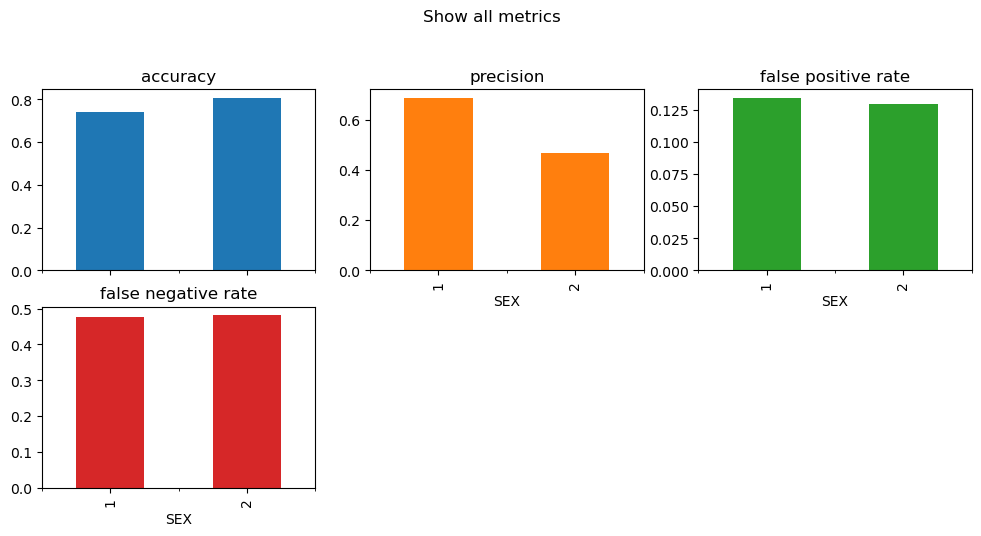

In [37]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=group_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In the data dictionary "1": Male, "2": Female

So overall we have good accuracy, almost equal parity (fairness) in both positive and negative classes, and but not so good precision (avg of precision in pos and neg class) for females. 

<Axes: >

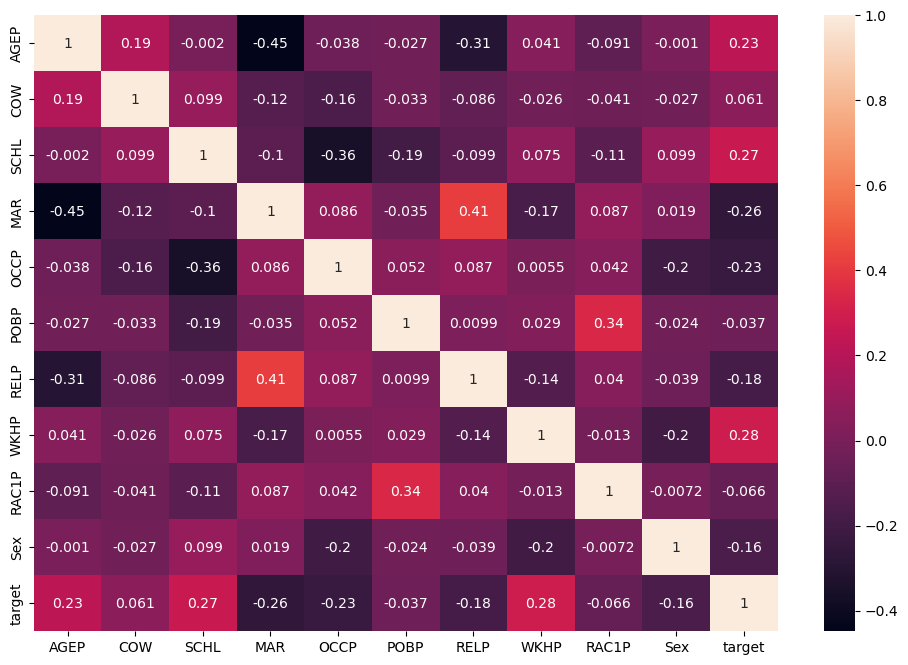

In [40]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
# Initialize LabelEncoder
label_encoders = {}
data_labenc=X_train.copy()
data_labenc['Sex']=group_train.copy()
data_labenc['target']=y_train.copy() ### we will use this later to visualize the whole data

# Iterate through categorical columns and apply Label Encoding
for column in data_labenc.select_dtypes(include=['object','category']).columns:
    label_encoders[column] = LabelEncoder()
    data_labenc[column] = label_encoders[column].fit_transform(data_labenc[column].astype(str))

# Compute the correlation matrix
correlation_matrix = data_labenc.corr()
plt.subplots(figsize=(12,8))
sns.heatmap(correlation_matrix,annot=True)

In [54]:
features=[ 'AGEP','SCHL', 'MAR','DIS','ESP','CIT','MIG','MIL', 'ANC','NATIVITY','DEAR',
        'DEYE','DREM','RAC1P','PUMA', 'OCCP','JWTR',
        'POWPUMA']

In [55]:
ACSIncome = folktables.BasicProblem(
                         features=features,
                        target='PINCP',
                        target_transform=lambda x: x > 50000,
                        group='SEX',
                        preprocess=folktables.acs.adult_filter,
                        postprocess=lambda x: np.nan_to_num(x, -1),
                    )

In [56]:
features, label, group = ACSIncome.df_to_pandas(acs_data)

In [57]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

<Axes: >

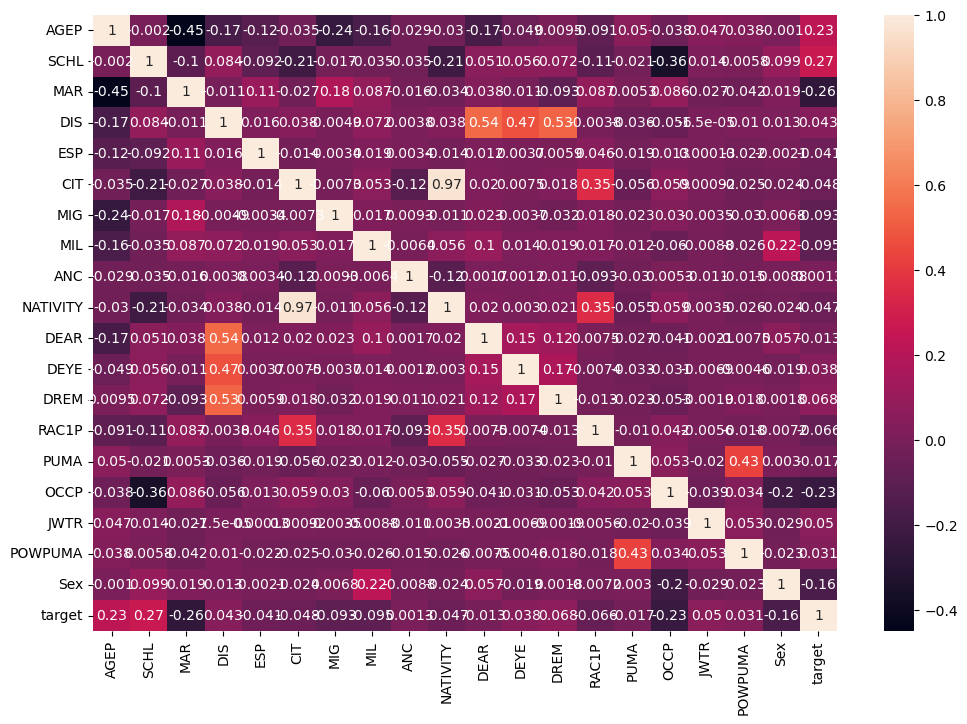

In [58]:
label_encoders = {}
data_labenc=X_train.copy()
data_labenc['Sex']=group_train.copy()
data_labenc['target']=y_train.copy() ### we will use this later to visualize the whole data

# Iterate through categorical columns and apply Label Encoding
for column in data_labenc.select_dtypes(include=['object','category']).columns:
    label_encoders[column] = LabelEncoder()
    data_labenc[column] = label_encoders[column].fit_transform(data_labenc[column].astype(str))

# Compute the correlation matrix
correlation_matrix = data_labenc.corr()
plt.subplots(figsize=(12,8))
sns.heatmap(correlation_matrix,annot=True)

In [60]:
classifier = DecisionTreeClassifier(min_samples_leaf=5, max_depth=8)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

array([[<Axes: title={'center': 'accuracy'}, xlabel='SEX'>,
        <Axes: title={'center': 'precision'}, xlabel='SEX'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='SEX'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='SEX'>,
        <Axes: xlabel='SEX'>, <Axes: xlabel='SEX'>],
       [<Axes: xlabel='SEX'>, <Axes: xlabel='SEX'>, <Axes: xlabel='SEX'>]],
      dtype=object)

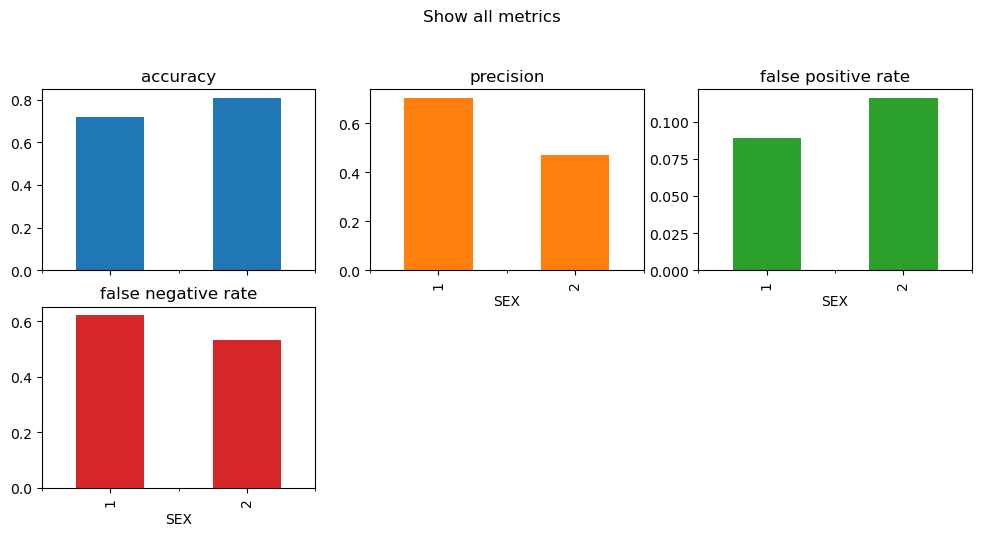

In [61]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=group_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

#### We see that the data became bit more difficult to train to. Hard is not necessarily bad data, but it conveys the message clearly that it is very important to select the features meaningfully

In [62]:
classifier = DecisionTreeClassifier(min_samples_leaf=5, max_depth=20)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

array([[<Axes: title={'center': 'accuracy'}, xlabel='SEX'>,
        <Axes: title={'center': 'precision'}, xlabel='SEX'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='SEX'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='SEX'>,
        <Axes: xlabel='SEX'>, <Axes: xlabel='SEX'>],
       [<Axes: xlabel='SEX'>, <Axes: xlabel='SEX'>, <Axes: xlabel='SEX'>]],
      dtype=object)

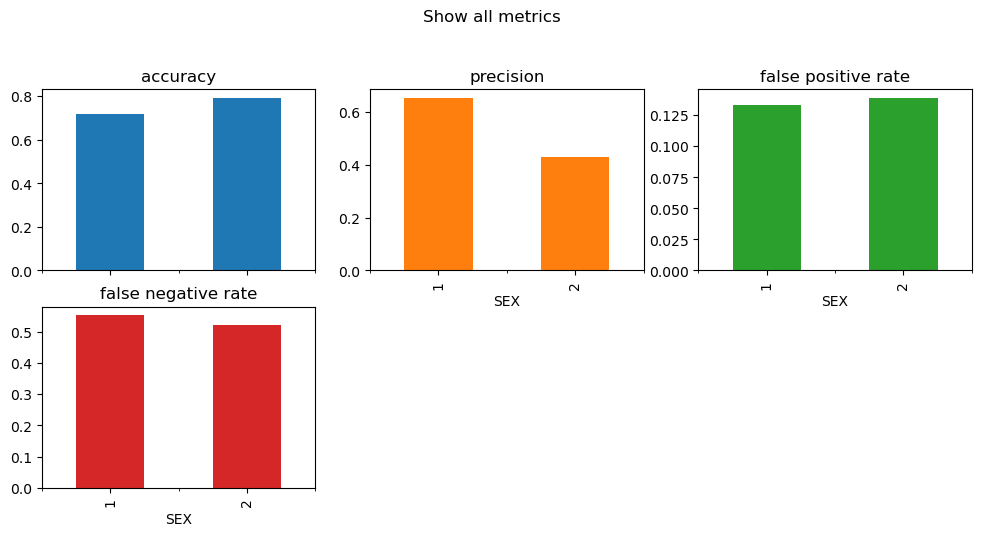

In [63]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=group_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

With a stronger classifier we are able to mimic the results on this hard data as we saw earlier on the data loaded with lesser features

#### Now lets play around with our own defined filters and tasks

In [65]:
def our_filter(data):
    df = data
    df = df[df['AGEP'] < 65]
    df = df[df['PINCP'] > 1000]
    df = df[df['WKHP'] > 2]
    df = df[df['PWGTP'] >= 1]
    return df

In [81]:
features=[ 'AGEP','SCHL', 'MAR','DIS','ESP','CIT','MIG','MIL', 'ANC','NATIVITY','DEAR',
        'DEYE','DREM','RAC1P','PUMA', 'OCCP','JWTR','GCL','WKHP',
        'ESR', 'OCCP', 'POWPUMA']


In [82]:
OurIncome = folktables.BasicProblem(
                         features=features,
                        target='PINCP',
                        target_transform=lambda x: x > 30000,
                        group='SEX',
                        preprocess=our_filter,
                        postprocess=lambda x: np.nan_to_num(x, -1),
                    )

In [83]:
features, label, group = OurIncome.df_to_pandas(acs_data)

In [84]:
features.shape

(12435, 22)

In [85]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

<Axes: >

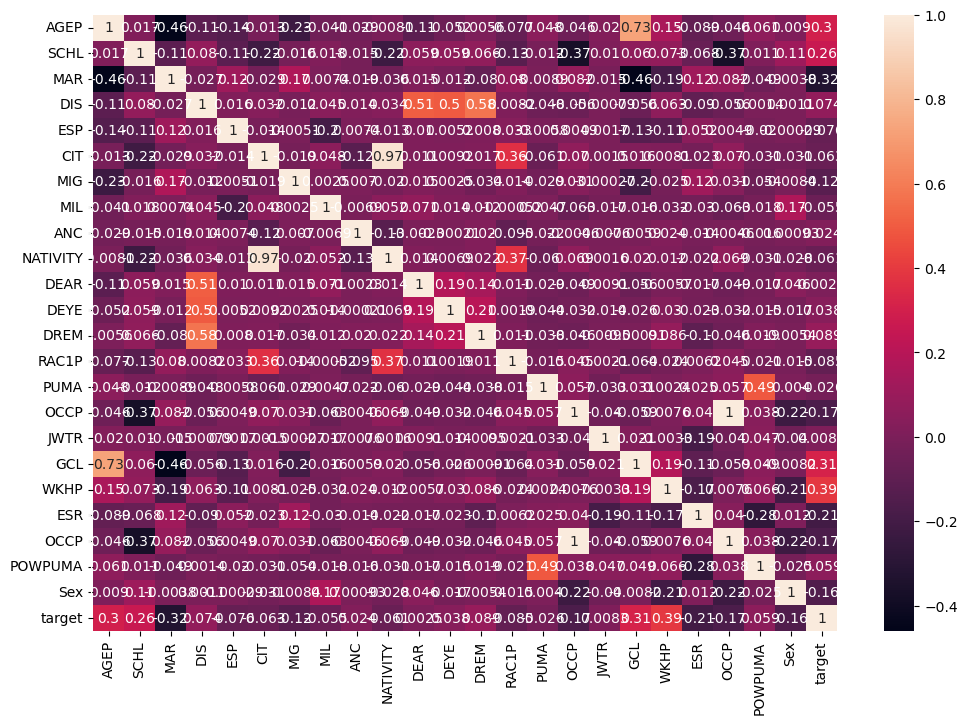

In [86]:
label_encoders = {}
data_labenc=X_train.copy()
data_labenc['Sex']=group_train.copy()
data_labenc['target']=y_train.copy() ### we will use this later to visualize the whole data

# Iterate through categorical columns and apply Label Encoding
for column in data_labenc.select_dtypes(include=['object','category']).columns:
    label_encoders[column] = LabelEncoder()
    data_labenc[column] = label_encoders[column].fit_transform(data_labenc[column].astype(str))

# Compute the correlation matrix
correlation_matrix = data_labenc.corr()
plt.subplots(figsize=(12,8))
sns.heatmap(correlation_matrix,annot=True)

In [87]:
classifier = DecisionTreeClassifier(min_samples_leaf=5, max_depth=20)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

array([[<Axes: title={'center': 'accuracy'}, ylabel='SEX'>,
        <Axes: title={'center': 'precision'}, ylabel='SEX'>,
        <Axes: title={'center': 'false positive rate'}, ylabel='SEX'>],
       [<Axes: title={'center': 'false negative rate'}, ylabel='SEX'>,
        <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>]],
      dtype=object)

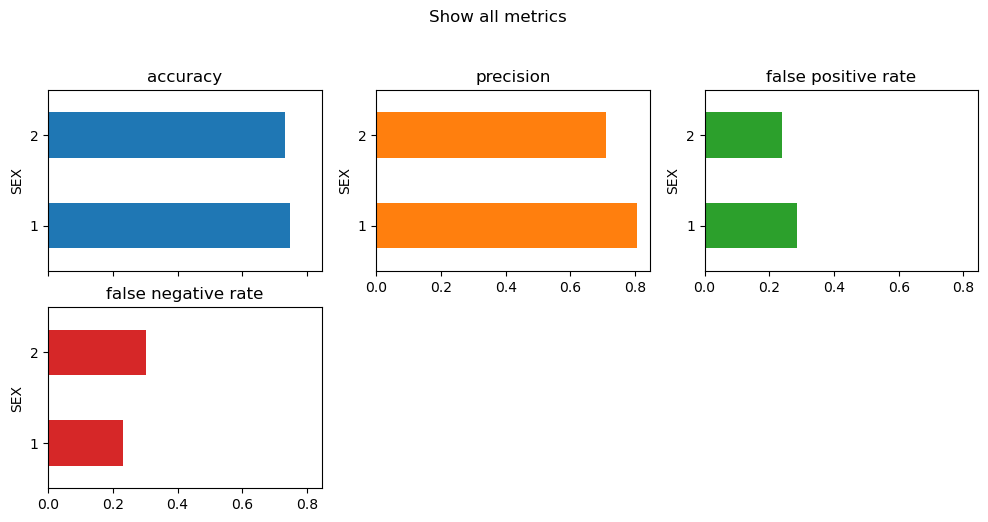

In [88]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=group_test
)
metric_frame.by_group.plot.barh(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

### Defining our own task

In [95]:
features=[ 'AGEP','SCHL', 'MAR','DIS','ESP','CIT','MIG','MIL', 'ANC','NATIVITY','DEAR',
        'DEYE','DREM','RAC1P','PUMA', 'OCCP','JWTR','GCL','PINCP',
        'ESR', 'OCCP', 'POWPUMA']

Hardworkers = folktables.BasicProblem(
                         features=features,
                        target='WKHP',
                        target_transform=lambda x: x > 45,
                        group='SEX',
                        preprocess=our_filter,
                        postprocess=lambda x: np.nan_to_num(x, -1),
                    )

In [96]:
features, label, group = Hardworkers.df_to_pandas(acs_data)

In [97]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

In [98]:
classifier = DecisionTreeClassifier(min_samples_leaf=5, max_depth=20)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

array([[<Axes: title={'center': 'accuracy'}, ylabel='SEX'>,
        <Axes: title={'center': 'precision'}, ylabel='SEX'>,
        <Axes: title={'center': 'false positive rate'}, ylabel='SEX'>],
       [<Axes: title={'center': 'false negative rate'}, ylabel='SEX'>,
        <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>]],
      dtype=object)

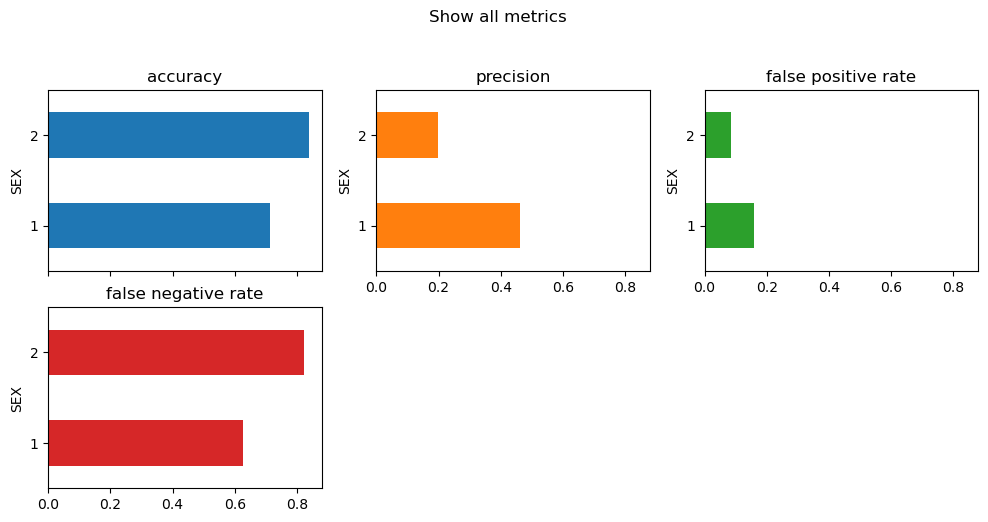

In [99]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=group_test
)
metric_frame.by_group.plot.barh(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [106]:
print("Class distribution: ", "Positive: ", (label*1).sum(), "Negative: ", label.shape[0]-(label*1).sum())

Class distribution:  Positive:  WKHP    2356
dtype: int64 Negative:  WKHP    10079
dtype: int64
